In [15]:
from google.colab import files
uploaded = files.upload()


Saving cleaned_data_combined_modified.csv to cleaned_data_combined_modified (1).csv


In [16]:
import pandas as pd
import re
import numpy as np

In [17]:
file_path = 'cleaned_data_combined_modified.csv'
try:
    df = pd.read_csv(file_path)
    print("✅ File loaded successfully")
except Exception as e:
    print(f"❌ Failed to load file: {e}")

✅ File loaded successfully


In [18]:
# Cleaning Q1

def clean_q1(text):
    if pd.isnull(text):
        return None

    text = str(text).strip().lower()

    # Extract the first digit between 1 and 5
    match = re.search(r'\b([1-5])\b', text)
    if match:
        return int(match.group(1))

    return None

# Locate Q1 column
q1_col = None
for col in df.columns:
    if 'q1' in col.strip().lower():
        q1_col = col
        break

if q1_col is None:
    raise ValueError("Q1 column not found.")
df.rename(columns={
    q1_col: "q1",

}, inplace=True)
q1_col = "q1"
# Apply cleaning function
df[q1_col] = df[q1_col].apply(clean_q1)

# Impute missing values with the median
df[q1_col] = df[q1_col].fillna(df[q1_col].median())

In [19]:
# Cleaning Q2

import re
import pandas as pd
import numpy as np

# Word-to-number mapping
word_to_number = {
    "zero": 0, "one": 1, "two": 2, "three": 3, "four": 4,
    "five": 5, "six": 6, "seven": 7, "eight": 8, "nine": 9,
    "ten": 10, "eleven": 11, "twelve": 12
}

def words_to_digits(text):
    for word, digit in word_to_number.items():
        pattern = r'\b' + word + r'\b'
        text = re.sub(pattern, str(digit), text)
    return text

def clean_q2(text):
    if pd.isnull(text):
        return None

    text = str(text).lower().strip()
    text = words_to_digits(text)
    text = re.sub(r'[:;]', '', text)  # Remove colons and semicolons
    text = re.sub(r'[$€£]|cad|canadian|dollars?|usd', '', text)
    text = re.sub(r'\s+', ' ', text)

    # Handle messy ranges like "3 - 5", "3to5", "3 or 4"
    range_pattern = r'(\d+(?:\.\d+)?)\s*(?:-|–|to|or|~|—)\s*(\d+(?:\.\d+)?)'
    range_match = re.search(range_pattern, text)
    if range_match:
        try:
            low = float(range_match.group(1))
            high = float(range_match.group(2))
            return round((low + high) / 2)
        except:
            pass

    # Extract all standalone numbers
    numbers = re.findall(r'\d+(?:\.\d+)?', text)

    # If user writes "x ingredients" (e.g., "5 ingredients"), prioritize that
    ing_match = re.search(r'(\d+(?:\.\d+)?)\s+ingredients?', text)
    if ing_match:
        return round(float(ing_match.group(1)))

    # Numeric list (comma/and-separated): count if clear list
    if ',' in text or ' and ' in text:
        items = re.split(r',| and ', text)
        items = [item.strip() for item in items if item.strip()]
        if items:
            return len(items)

    # General fallback: average all numbers found
    if len(numbers) > 1:
        return round(sum(map(float, numbers)) / len(numbers))
    elif len(numbers) == 1:
        return round(float(numbers[0]))

    # Handle vague terms
    vague_words = ['many', 'a lot', 'several', 'tons', 'bunch', 'plenty', 'idk', 'don’t know', "don't know", 'not sure']
    if any(word in text for word in vague_words):
        return None

    return None

# Locate Q2 column
q2_col = next((col for col in df.columns if 'q2' in col.strip().lower()), None)
if q2_col is None:
    raise ValueError("Q2 column not found.")
df.rename(columns={
    q2_col: "q2",

}, inplace=True)
q2_col = "q2"
# Apply cleaning function and fill missing with median
df[q2_col] = df[q2_col].apply(clean_q2)
df[q2_col] = df[q2_col].fillna(df[q2_col].median())

print(f"✅ Q2 cleaned. Example values:\n{df[q2_col].head(30)}")


✅ Q2 cleaned. Example values:
0      6.0
1      2.0
2      5.0
3      5.0
4      3.0
5      6.0
6      4.0
7      5.0
8      5.0
9      9.0
10    10.0
11     6.0
12     4.0
13     4.0
14     8.0
15     5.0
16     7.0
17     6.0
18    21.0
19     6.0
20    10.0
21     5.0
22     5.0
23    10.0
24     6.0
25     6.0
26    10.0
27     5.0
28     3.0
29     5.0
Name: q2, dtype: float64


In [20]:
# Cleaning Q3

# List of known settings (lowercased)
setting_options = {
    'is_Week_day_lunch': 'week day lunch',
    'is_Week_day_dinner': 'week day dinner',
    'is_Weekend_lunch': 'weekend lunch',
    'is_Weekend_dinner': 'weekend dinner',
    'is_At_a_party': 'at a party',
    'is_Late_night_snack': 'late night snack'
}

# Locate Q3 column
q3_col = None
for col in df.columns:
    if 'q3' in col.strip().lower():
        q3_col = col
        break

if q3_col is None:
    raise ValueError("Q3 column not found.")

# Create binary columns for each setting
for new_col, keyword in setting_options.items():
    df[new_col] = df[q3_col].apply(
        lambda x: 1 if isinstance(x, str) and keyword in x.lower() else 0
    )

# Drop the original Q3 column
df.drop(columns=[q3_col], inplace=True)


In [21]:
import re
import pandas as pd
import numpy as np

def clean_q4(text):
    """
    Cleans Q4 price estimates:
    - Extracts and averages ranges or multiple values
    - Removes currency symbols/words
    - Handles messy structures and floating point numbers
    """
    if pd.isnull(text):
        return None

    text = str(text).lower().strip()
    text = re.sub(r'\s+', ' ', text)  # Normalize excessive spaces
    text = re.sub(r'[$€£]|cad|canadian|dollars?|usd', '', text)  # Remove currency references
    text = text.replace('~', '-')

    # Handle range expressions like "5-10", "5 to 10", "5 or 10"
    range_pattern = r'(\d+(?:\.\d+)?)\s*(?:-|to|or|–|—)\s*(\d+(?:\.\d+)?)'
    range_match = re.search(range_pattern, text)
    if range_match:
        try:
            low = float(range_match.group(1))
            high = float(range_match.group(2))
            return round((low + high) / 2)
        except:
            pass

    # Extract ALL numbers (may include noise like "one slice $3, full pizza $15")
    all_numbers = re.findall(r'\d+(?:\.\d+)?', text)
    if all_numbers:
        all_numbers = [float(num) for num in all_numbers]
        avg = sum(all_numbers) / len(all_numbers)
        return round(avg)

    return None

# Locate Q4 column
q4_col = next((col for col in df.columns if 'q4' in col.strip().lower()), None)
if q4_col is None:
    raise ValueError("Q4 column not found.")
df.rename(columns={
    q4_col: "q4",

}, inplace=True)
q4_col = "q4"

# Apply cleaning
df[q4_col] = df[q4_col].apply(clean_q4)
df[q4_col] = df[q4_col].fillna(df[q4_col].median())

print(f"✅ Q4 cleaned. Example values:\n{df[q4_col].head(10)}")


✅ Q4 cleaned. Example values:
0     5.0
1     5.0
2    10.0
3     3.0
4     5.0
5    15.0
6     1.0
7    20.0
8     3.0
9     4.0
Name: q4, dtype: float64


In [22]:
# CLeaning Q5

import re
from collections import Counter
import numpy as np
import pandas as pd


def tokenize(text):
    """
    Tokenizes input text: lowercase, remove punctuation, split by whitespace.
    """
    if not isinstance(text, str):
        return []
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    return text.split()

def process_q5_bow(df, top_n=50, binary=True):
    """
    Converts Q5 text responses into Bag-of-Words features.

    Args:
        df: Input DataFrame
        top_n: Keep top N most frequent tokens
        binary: If True, encodes presence (1) or absence (0). If False, uses frequency count.

    Returns:
        DataFrame with new BoW features and Q5 column removed.
    """
    # Locate Q5 column
    q5_col = next((col for col in df.columns if 'q5' in col.strip().lower()), None)
    if q5_col is None:
        raise ValueError("Q5 column not found in the dataset.")

    # Tokenize Q5 responses
    token_lists = df[q5_col].fillna('').apply(tokenize)

    # Count total frequencies
    term_freq = Counter()
    for tokens in token_lists:
        term_freq.update(tokens)

    # Select top-N vocabulary
    vocab = [term for term, _ in term_freq.most_common(top_n)]
    vocab_set = set(vocab)

    # Create BoW features
    bow_features = []
    for tokens in token_lists:
        token_counts = Counter(tokens)
        row = {}
        for word in vocab:
            if binary:
                row[f"q5_bow_{word}"] = int(word in token_counts)
            else:
                row[f"q5_bow_{word}"] = token_counts[word]
        bow_features.append(row)

    bow_df = pd.DataFrame(bow_features)

    # Concatenate BoW with original df (drop original Q5 column)
    df = df.drop(columns=[q5_col])
    df = pd.concat([df, bow_df], axis=1)

    return df

   #drop the 5 the colo





In [23]:

# Locate Q6 column
q6_col = next((col for col in df.columns if 'q6' in col.strip().lower()), None)
if q6_col is None:
    raise ValueError("Q6 column not found.")

# Define drink categories
drink_keywords = {
    'is_soda': [
        'soda', 'cola', 'coke', 'coca', 'sprite', 'fanta',
        'root beer', 'dr pepper', 'pepsi', '7up', 'mountain dew', 'cream soda', 'seven up'
    ],
    'is_juice': [
        'juice', 'orange juice', 'apple juice', 'grape juice', 'cranberry', 'lemonade'
    ],

    'is_water': [
        'water', 'bottled water', 'tap water', 'sparkling water'
    ],
    'is_tea': [
        'tea', 'iced tea', 'green tea', 'bubble tea'
    ],
    'is_coffee': [
        'coffee', 'latte', 'espresso', 'cappuccino', 'cold brew'
    ],
    'is_milk': [
        'milk', 'chocolate milk', 'almond milk', 'soy milk', 'oat milk'
    ]
}

# Clean and encode each category
def detect_drink_category(text, keywords):
    if not isinstance(text, str):
        return 0
    text = text.lower()
    return 1 if any(kw in text for kw in keywords) else 0

# Apply to dataframe
for col_name, keywords in drink_keywords.items():
    df[col_name] = df[q6_col].apply(lambda x: detect_drink_category(x, keywords))

# Drop original Q6 column
df.drop(columns=[q6_col], inplace=True)

print("✅ Q6 cleaned into multiple drink categories.")


✅ Q6 cleaned into multiple drink categories.


In [24]:
# Cleaning Q7

q7_col = None
for col in df.columns:
    if 'q7' in col.strip().lower():
        q7_col = col
        break

if q7_col is None:
    raise ValueError("Q7 column not found.")

# Define group keywords
q7_targets = {
    'is_Parents': 'parents',
    'is_Siblings': 'siblings',
    'is_Friends': 'friends',
    'is_Teachers': 'teachers',
    'is_Strangers': 'strangers'
}

# Create binary columns for each group
for new_col, keyword in q7_targets.items():
    df[new_col] = df[q7_col].apply(
        lambda x: 1 if isinstance(x, str) and keyword in x.lower() else 0
    )

# Drop original Q7 column
df.drop(columns=[q7_col], inplace=True)


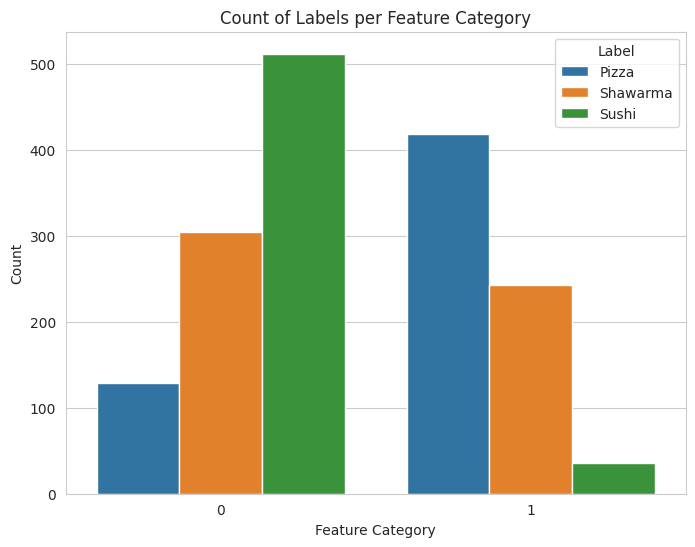

In [25]:
# Cleaning Q8

# Locate Q8 column
q8_col = None
for col in df.columns:
    if 'q8' in col.strip().lower():
        q8_col = col
        break

if q8_col is None:
    raise ValueError("Q8 column not found.")

# Map known responses to spice levels
def map_spice_level(text):
    if not isinstance(text, str):
        return 0  # Default for missing

    t = text.lower()
    if 'none' in t:
        return 0
    elif 'mild' in t or 'little' in t:
        return 1
    elif 'moderate' in t or 'medium' in t:
        return 2
    elif 'hot' in t and 'lot' in t:
        return 3
    elif 'my hot sauce' in t:
        return 4  # enthusiastic
    else:
        return 0  # fallback

# Apply to dataset
df['spice_level'] = df[q8_col].apply(map_spice_level)

# Drop original column
df.drop(columns=[q8_col], inplace=True)

# Drop the ID column if it exists
if "id" in df.columns:
    df.drop(columns=["id"], inplace=True)
# Locate Q5 column
q5_col = next((col for col in df.columns if 'q5' in col.strip().lower()), None)

df.drop(columns=[q5_col], inplace=True)



import seaborn as sns
import matplotlib.pyplot as plt

# Count plot: visualize the count of each label within each category of the feature
plt.figure(figsize=(8, 6))
sns.countplot(x='is_soda', hue='Label', data=df)
plt.title("Count of Labels per Feature Category")
plt.xlabel("Feature Category")
plt.ylabel("Count")
plt.show()


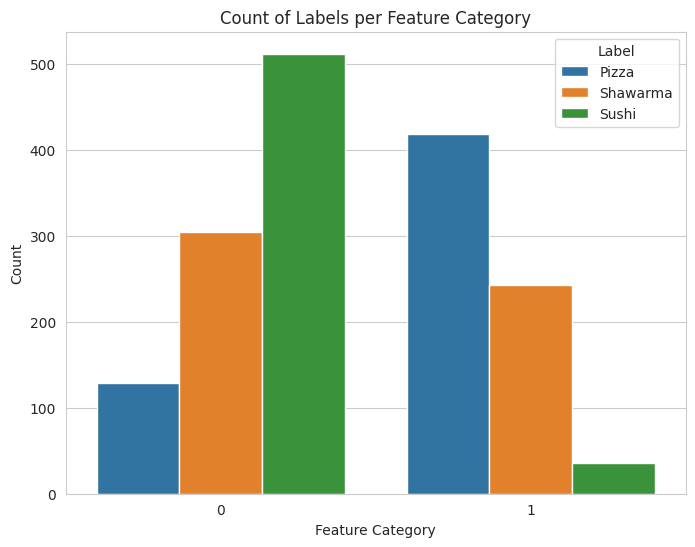

In [26]:
# Count plot: visualize the count of each label within each category of the feature
plt.figure(figsize=(8, 6))
sns.countplot(x='is_soda', hue='Label', data=df)
plt.title("Count of Labels per Feature Category")
plt.xlabel("Feature Category")
plt.ylabel("Count")
plt.show()

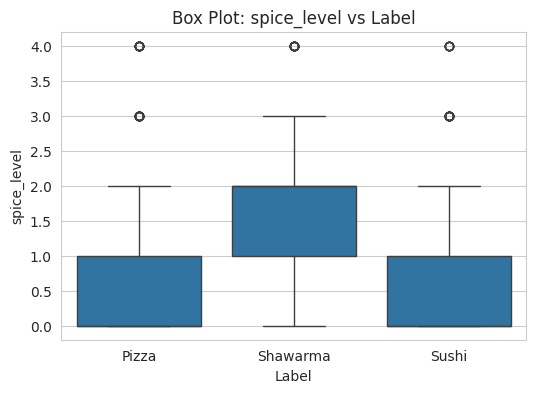

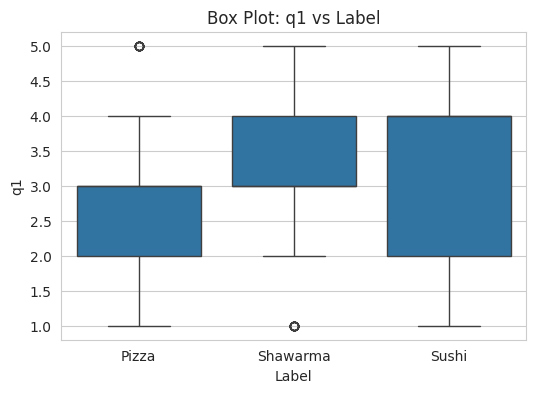

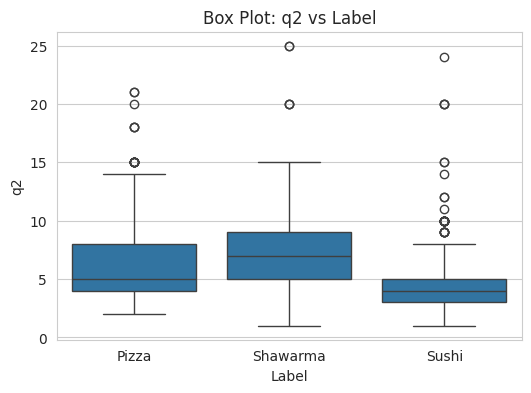

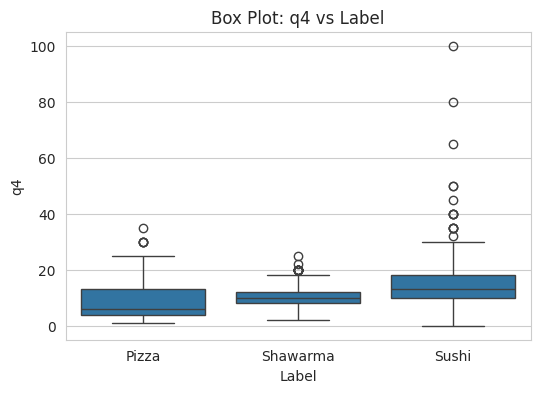

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt

# If you'd like a specific style (optional)
sns.set_style("whitegrid")

top_features = ['spice_level','q1','q2', 'q4']

for feature in top_features:
    plt.figure(figsize=(6, 4))
    # x is your categorical variable (Label), y is your numeric feature
    sns.boxplot(x="Label", y=feature, data=df)
    plt.title(f"Box Plot: {feature} vs Label")
    plt.xlabel("Label")
    plt.ylabel(feature)
    plt.show()

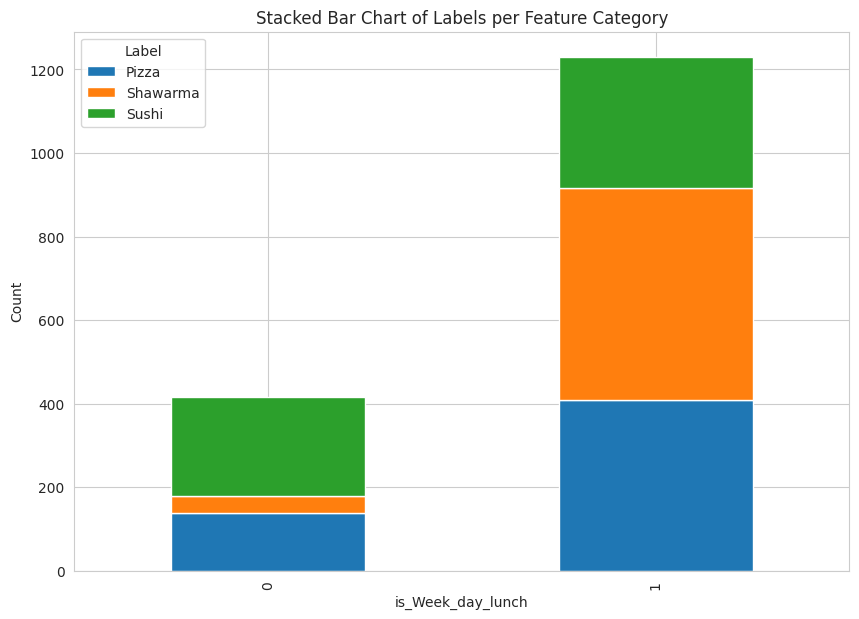

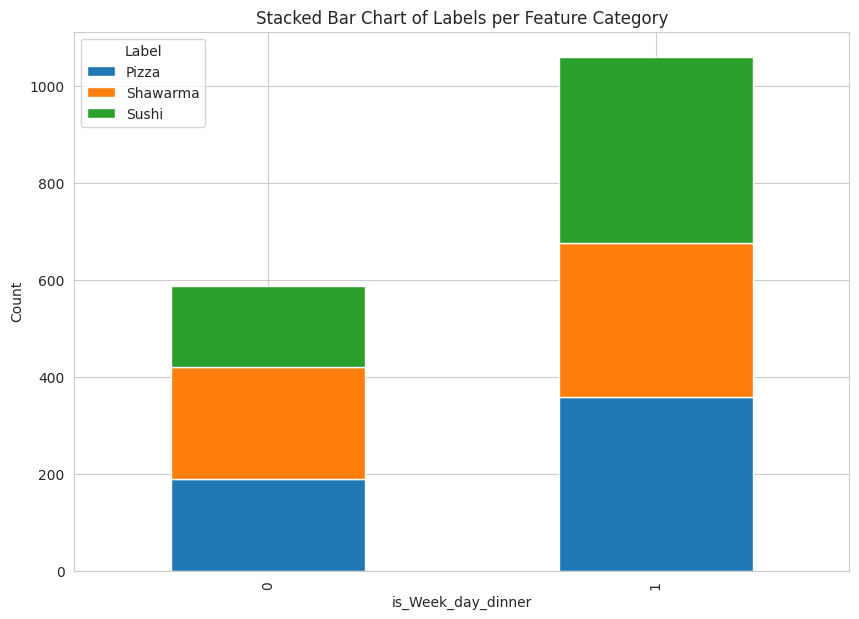

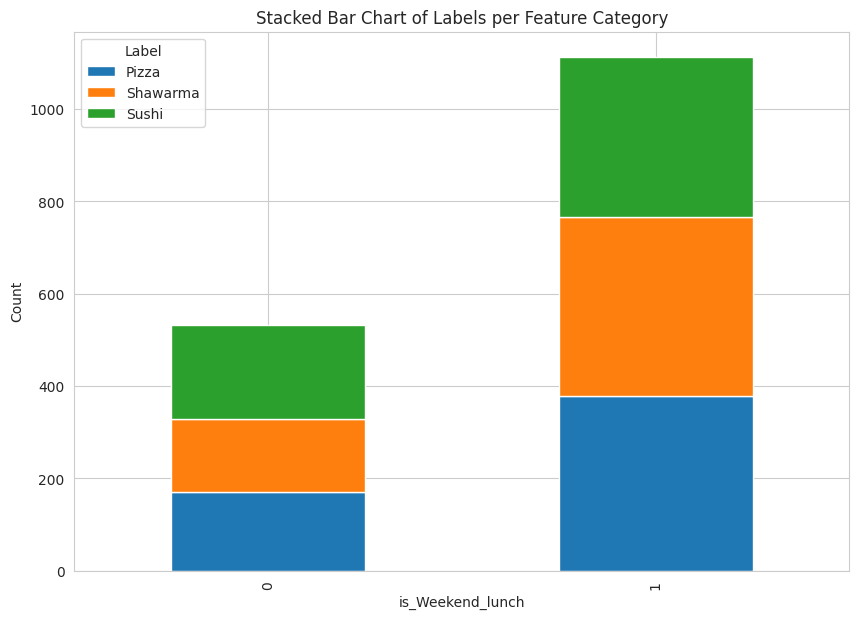

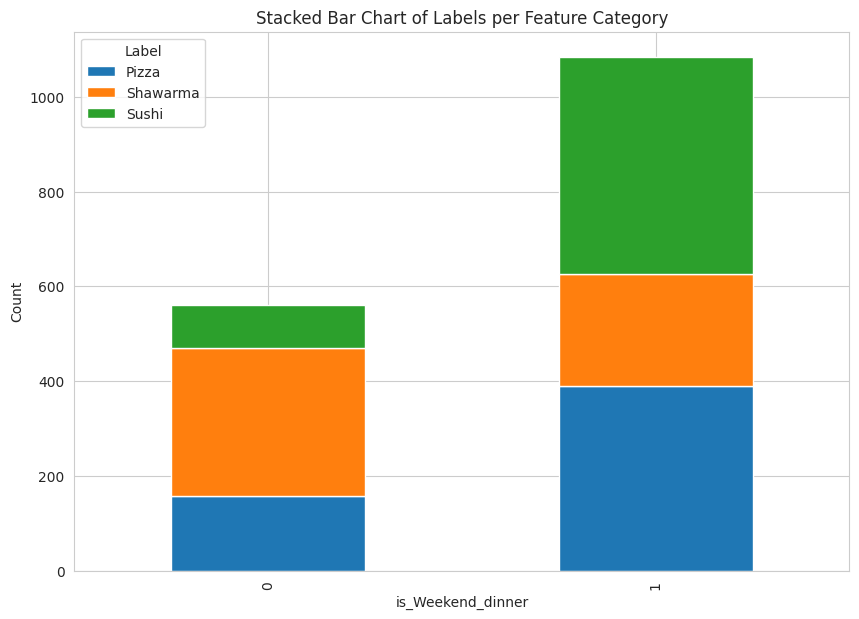

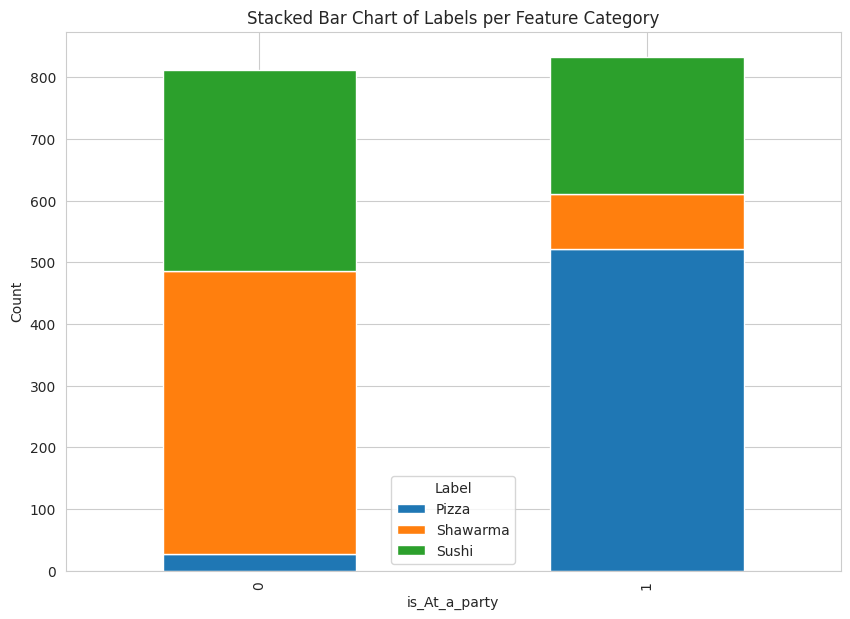

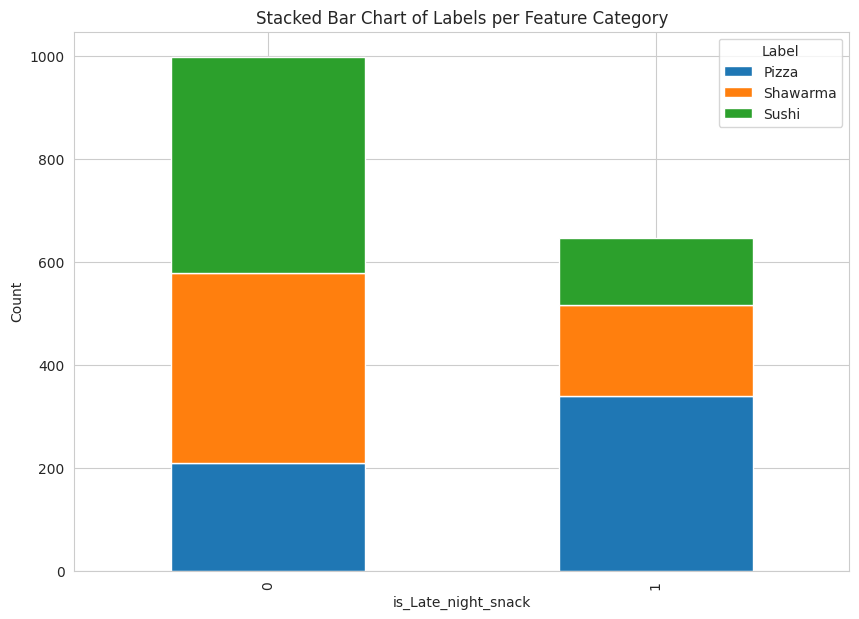

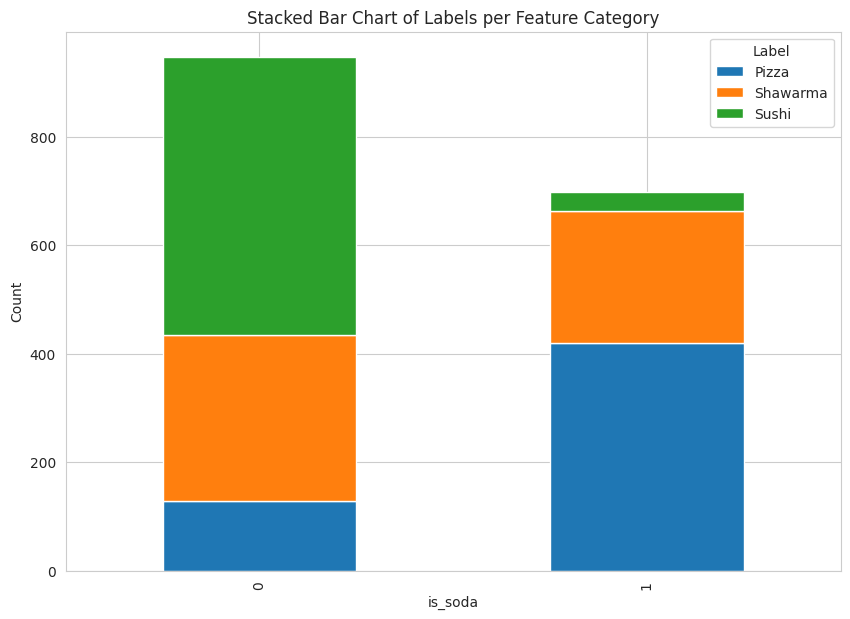

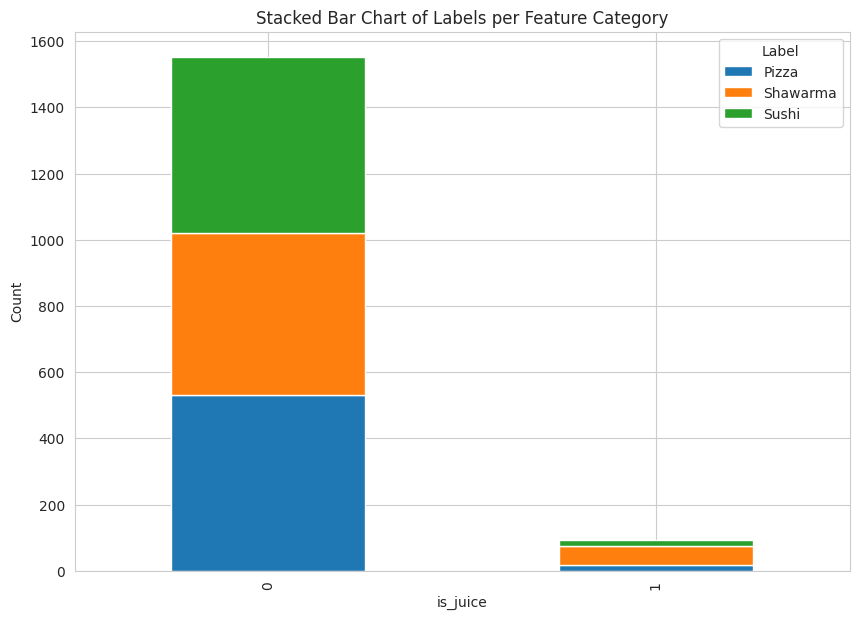

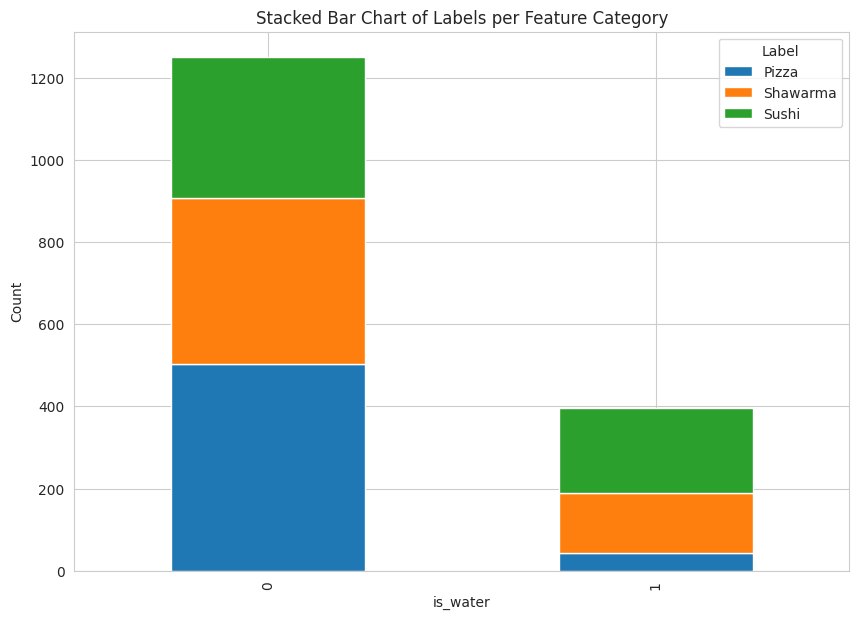

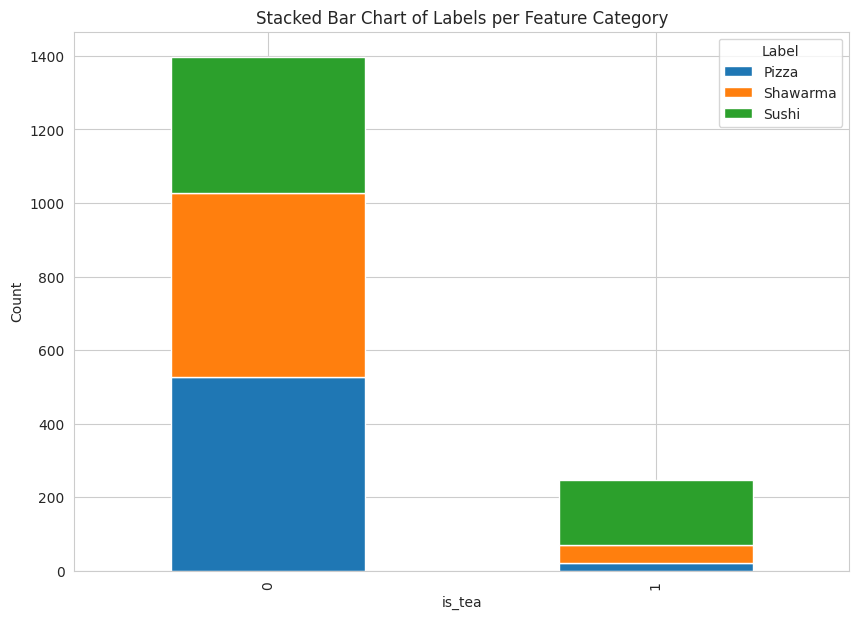

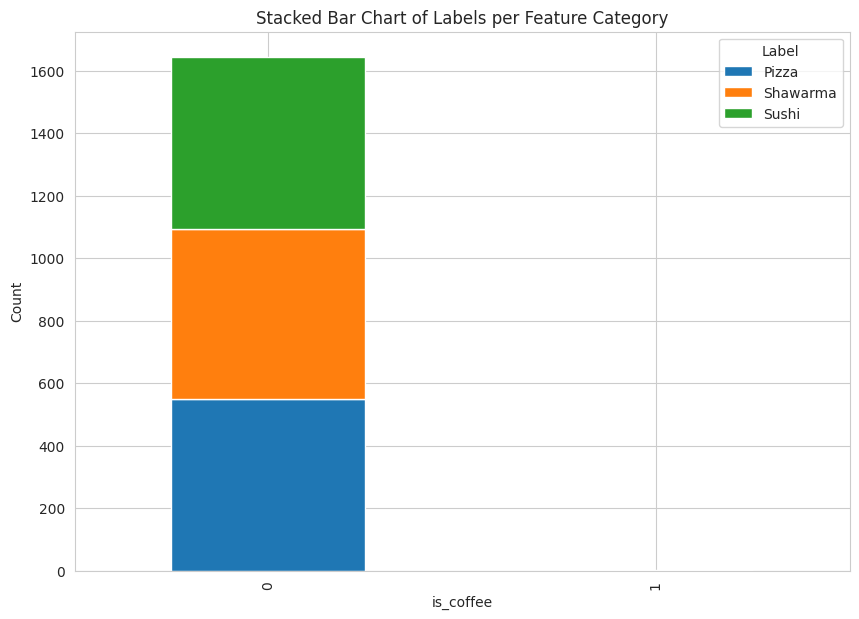

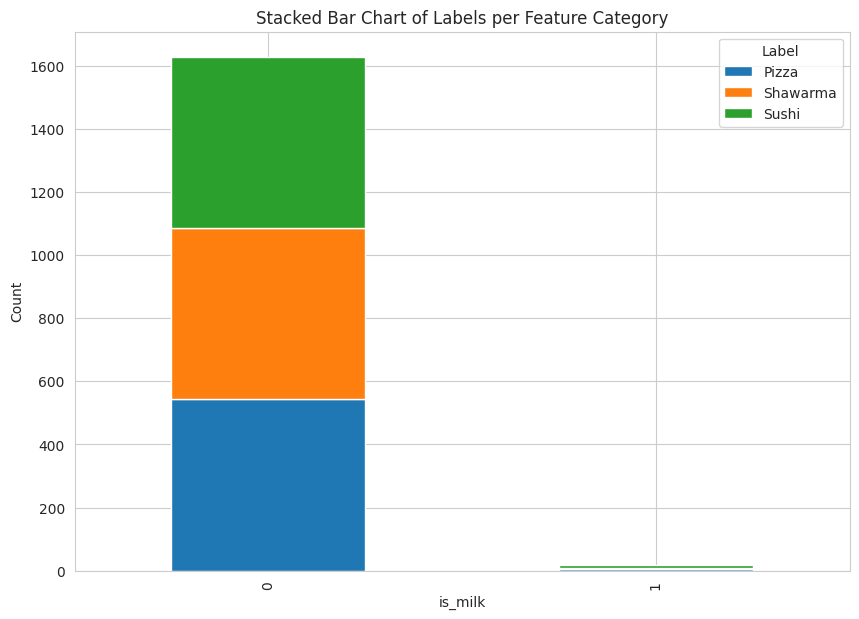

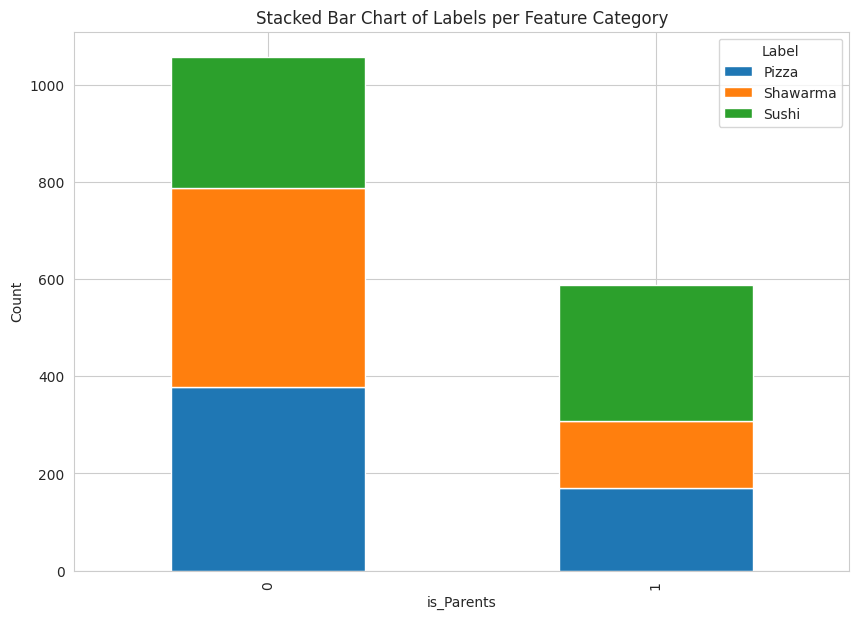

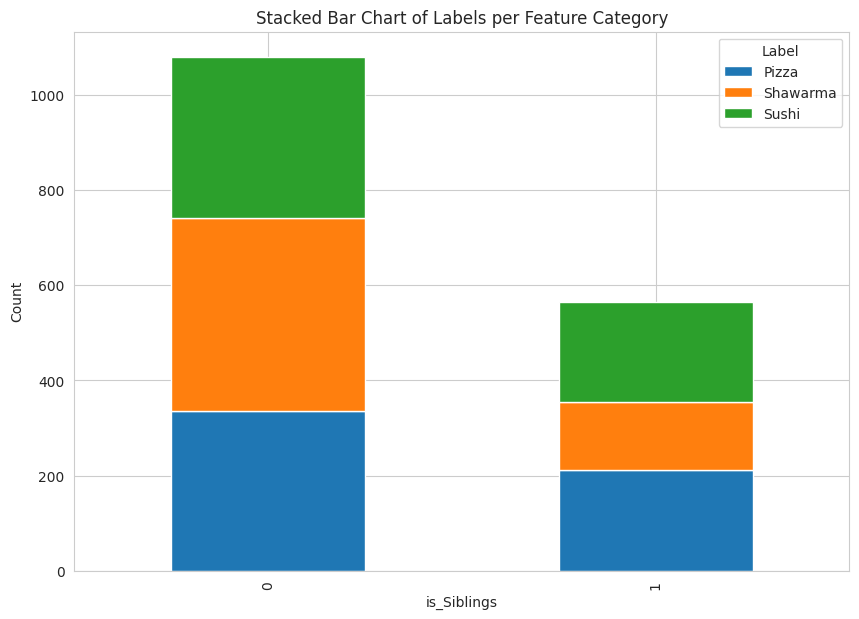

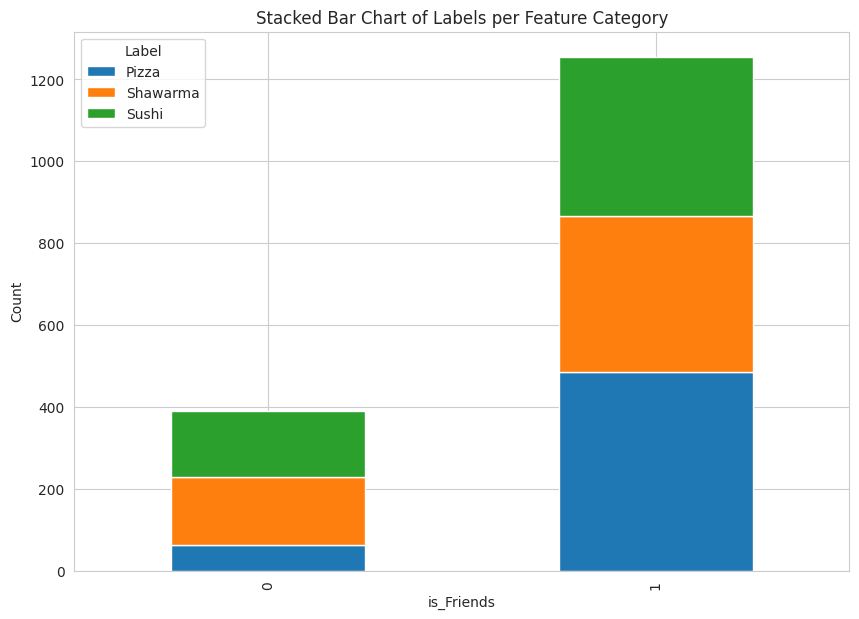

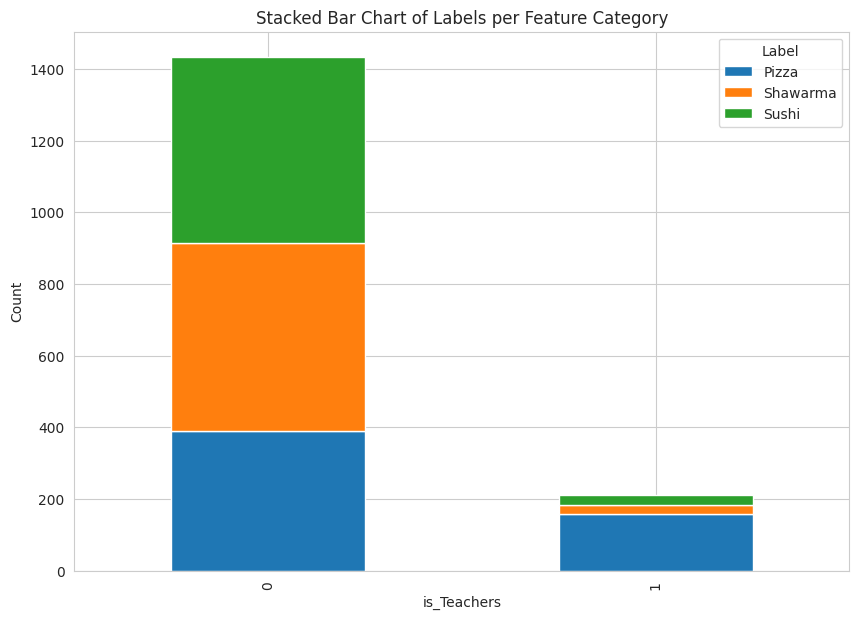

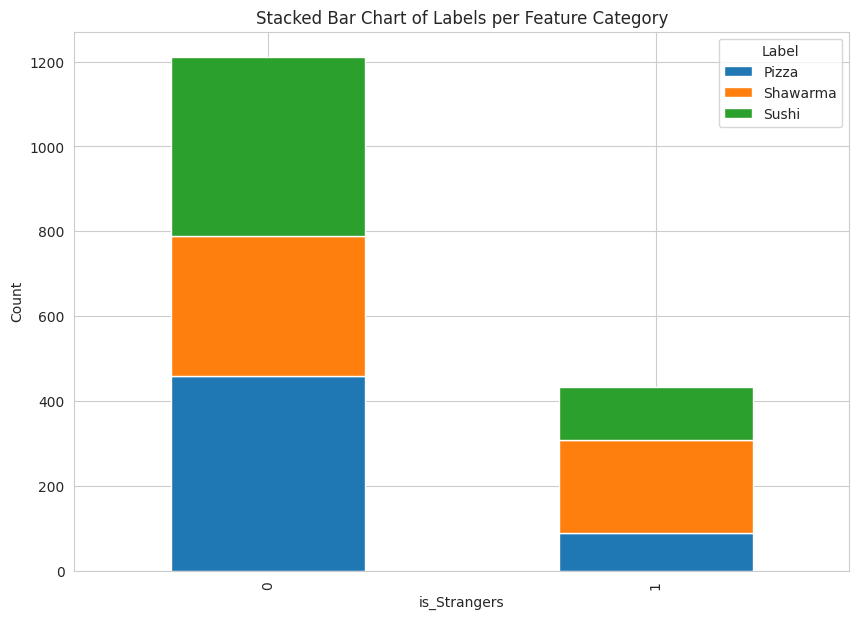

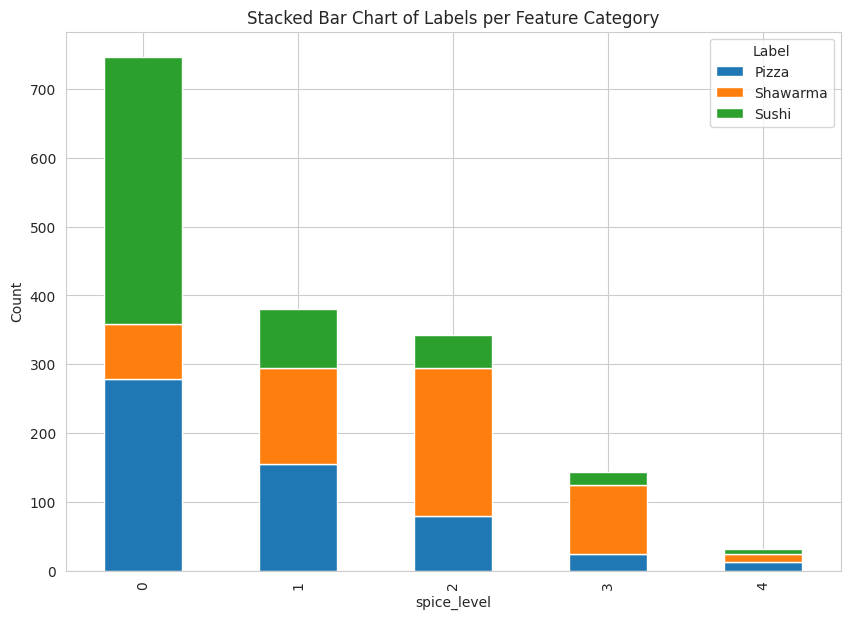

In [28]:
import pandas as pd
import matplotlib.pyplot as plt

is_features = [col for col in df.columns if col.startswith('is_')]
is_features.append('spice_level')
for feature in is_features:
  # Create a crosstab of feature vs label counts
  ct = pd.crosstab(df[feature], df['Label'])

  # Plot the crosstab as a stacked bar chart
  ct.plot(kind='bar', stacked=True, figsize=(10, 7))
  plt.title("Stacked Bar Chart of Labels per Feature Category")
  plt.xlabel(feature)
  plt.ylabel("Count")
  plt.legend(title="Label")
  plt.show()